In [1]:
import os
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import numpy as np
import calendar
from dateutil import parser

In [2]:
SRC_DIR = os.path.dirname(os.getcwd())

In [3]:
# connect to DB
SRC_DIR = os.path.dirname(os.getcwd())
dbname = "quickbooks.db"
dbpath = os.path.join(SRC_DIR,"db",dbname)
conn = sqlite3.connect(dbpath) 
qbdf = pd.read_sql("select * from categorized_items", conn)

In [4]:
budget_file = os.path.join(SRC_DIR,'config','qb_to_budget_map.csv')
budgetdf = pd.read_csv(budget_file)

In [5]:
# data manipulation
qbdf['item'] = qbdf['category'].apply(lambda x: x.split(':')[-1])
qbdf['Amount'] = qbdf['Amount'].astype(float)
qbdf['Account_Type'] = qbdf['category'].apply(lambda x: x.split(':')[0])
qbdf['Date'] = pd.to_datetime(qbdf['Date'])

budgetdf['Budget'] = budgetdf['Budget']*12.0
budget_items = budgetdf['QB_Item'].unique()

expenses = qbdf.loc[qbdf['Account_Type']=='Expenses']
income = qbdf.loc[qbdf['Account_Type'] == 'Income']

# check for unrecognized types and categories
types = qbdf["Transaction Type"].unique()
expected_types = ['Check','Expense','Deposit']
for t in types:
    if t not in expected_types:
        print(f"Warning: {t} not a recognized type")

for item in expenses['item'].unique():
    if item not in budget_items:
        print(f"Warning: {item} not in any budget category")

In [6]:
expenses.loc[expenses['item']=='Bank Fee']

,Date,Transaction Type,Num,Name,Memo/Description,Split,Amount,Balance,category,category_level,item,Account_Type


In [21]:
item_totals = expenses.groupby('item').aggregate({"Amount":"sum","Date":'count'}).reset_index()
item_totals.columns = ['item','Amount','Transactions']
all_totals = pd.merge(budgetdf,item_totals, left_on='QB_Item', right_on="item", how = 'left')
subcategory_totals = all_totals.groupby("Subcategory").aggregate({"Budget":"sum","Amount":"sum"}).reset_index()

In [22]:
total_expense = expenses['Amount'].sum()
total_income = income['Amount'].sum()
net_profit = total_income - total_expense

In [23]:
year = 2023
for month in range(1,9):
    days = calendar.monthrange(year,month)[1]
    month_name = calendar.month_name[month]
    print(f"Grabbing report details for {month_name}")

Grabbing report details for January
Grabbing report details for February
Grabbing report details for March
Grabbing report details for April
Grabbing report details for May
Grabbing report details for June
Grabbing report details for July
Grabbing report details for August


## YTD Reports

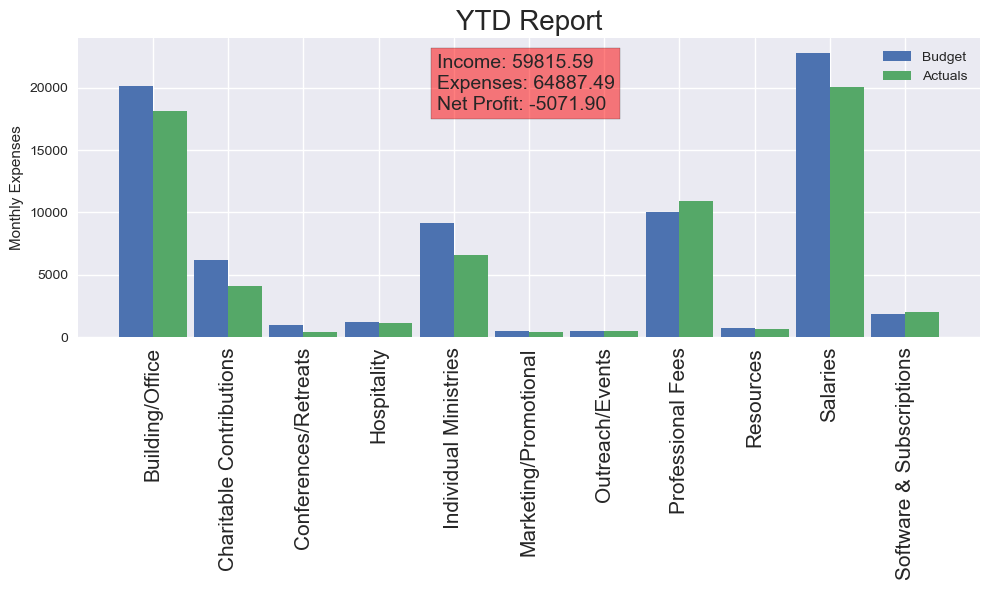

In [24]:
fig, ax = plt.subplots(figsize = (10,6))
ind = np.arange(len(subcategory_totals))
width = 0.45
budget = ax.bar(ind, subcategory_totals['Budget'], width, label = "Budget")
actual = ax.bar(ind+width, subcategory_totals["Amount"], width, label="Actuals")
ax.set_ylabel("Monthly Expenses")
ax.set_title("YTD Report", fontsize=20)
midx = ind.mean()
midy = max([subcategory_totals['Budget'].max(), subcategory_totals["Amount"].max()])*0.8
color = 'green'
if net_profit>0:
    color = 'green'
else:
    color = 'red'
ax.text(midx-1, midy, 'Income: {:.2f}\nExpenses: {:.2f}\nNet Profit: {:.2f}'.format(total_income,total_expense, net_profit), fontsize=14, bbox=dict(facecolor=color, alpha=0.5))
ax.legend()

ax.set_xticks(ind+width/2, subcategory_totals['Subcategory'], rotation=90, fontsize=15)
plt.tight_layout()
plt.savefig('YTD.png')

In [43]:
special_account = expenses[expenses['item']=="Utilities"]

In [44]:
special_account[['Date','Amount','Transaction Type']]

,Date,Amount,Transaction Type
25,2023-01-27,576.60,Expense
77,2023-02-27,505.99,Expense
130,2023-03-28,367.15,Expense
224,2023-05-01,341.54,Expense
225,2023-05-30,343.24,Expense
266,2023-06-28,302.72,Expense
315,2023-07-28,629.17,Expense
367,2023-08-29,617.17,Expense
401,2023-09-28,586.76,Expense
446,2023-10-27,440.60,Expense


Text(0.5, 1.0, 'Utilities Payments')

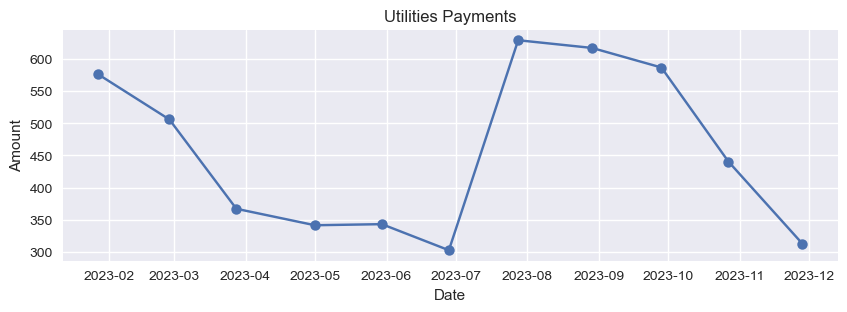

In [49]:
fig, ax = plt.subplots(figsize=(10,3))
x = special_account['Date']
y = special_account['Amount']
ax.plot(x,y, marker='.', markersize=15)
ax.set_ylabel("Amount")
ax.set_xlabel("Date")
#ax.text(list(x)[-1],list(y)[-1]+50,f"{round(list(y)[-1],2)}",size=15)
ax.set_title("Utilities Payments")

In [29]:
all_totals[~all_totals['item'].isin(['Lead Pastor','Associate Pastor'])].sort_values(['Amount'], ascending=False).head(10)[['Category','Subcategory','item','Amount','Transactions']]

,Category,Subcategory,item,Amount,Transactions
7,Facilities,Building/Office,Repair and Maintenance,5822.75,6.0
13,Facilities,Professional Fees,Utilities,5023.95,11.0
6,Facilities,Building/Office,Updates/Renovations,4958.46,2.0
11,Facilities,Building/Office,Church Insurance,4554.00,4.0
16,Facilities,Professional Fees,Lawn/Snow,4375.89,20.0
30,Ministry,Individual Ministries,Honorarium/Blessing,2902.44,5.0
21,Facilities,Software & Subscriptions,Software and Subscriptions,2013.27,46.0
23,Ministry,Individual Ministries,Ministry Network,1980.00,1.0
37,Giving,Charitable Contributions,Joel Frees,1337.58,4.0
38,Giving,Charitable Contributions,Crossfire,1332.00,4.0


In [30]:
start_time = parser.parse('2023-01-01')
end_time = parser.parse('2024-01-01')
expense_max_date = expenses['Date'].max()
income_max_date = income['Date'].max()

# trim data set to time period of interest and remove special accounts
period_expenses = expenses.loc[(expenses['Date']>=start_time) & (expenses['Amount']<4000)]
period_income = income.loc[(income['Date']>=start_time) & (income['item']!="Worship Contribution") & (income['item']!='Olive Tree (Tenant Lease)')]

expense_days = (expense_max_date - start_time).days
income_days = (income_max_date - start_time).days


expense_per_day = period_expenses['Amount'].sum() / expense_days
income_per_day = period_income['Amount'].sum() / income_days


remaining_expenses = expense_per_day * (end_time - expense_max_date).days
remaining_income = income_per_day * (end_time - income_max_date).days

projected_expense_total = remaining_expenses + expenses['Amount'].sum()
projected_income_total = remaining_income + income['Amount'].sum()

print(f"Projected Expenses: {projected_expense_total}")
print(f"Projected Income: {projected_income_total}")
print(f"Projected Net Profit: {projected_income_total-projected_expense_total}")

Projected Expenses: 68503.12457725947
Projected Income: 62513.62734104047
Projected Net Profit: -5989.497236219002


In [31]:
print(f"Income: {income['Amount'].sum()}")
print(f"Expenses: {expenses['Amount'].sum()}")
print(f"Net Profit: {income['Amount'].sum()-expenses['Amount'].sum()}")

Income: 59815.590000000004
Expenses: 64887.49
Net Profit: -5071.899999999994


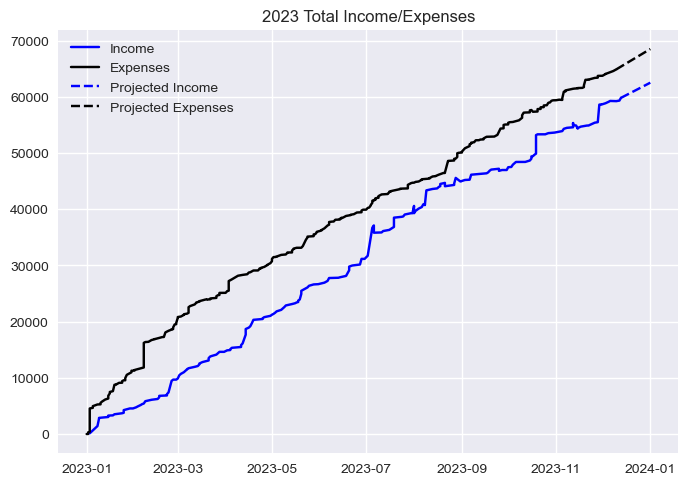

In [34]:
fig, ax = plt.subplots()
expense_line = expenses.sort_values('Date')[['Amount','Date']]
expense_line['Amount'] = expense_line['Amount'].cumsum()
income_line = income.sort_values('Date')[['Amount','Date']]
income_line['Amount'] = income_line['Amount'].cumsum()
ax.plot(income_line['Date'], income_line['Amount'], color='blue', label="Income")
ax.plot(expense_line['Date'],expense_line['Amount'], color='black', label="Expenses")
projected_income_dates = [list(income_line.tail(1)['Date'])[0], parser.parse('2024-01-01')]
projected_income_line = [list(income_line.tail(1)['Amount'])[0], projected_income_total]
projected_expense_dates = [list(expense_line.tail(1)['Date'])[0], parser.parse('2024-01-01')]
projected_expense_line = [list(expense_line.tail(1)['Amount'])[0], projected_expense_total]
ax.plot(projected_income_dates,projected_income_line,linestyle='--',color='blue', label="Projected Income")
ax.plot(projected_expense_dates,projected_expense_line,linestyle='--',color='black', label="Projected Expenses")
ax.legend()
ax.set_title("2023 Total Income/Expenses")
plt.savefig('total_income_expense_projections.png')

In [35]:
expense_line = pd.concat([expense_line,pd.DataFrame({'Amount':remaining_expenses,'Date':parser.parse('2024-01-01')},index=[0])])
income_line = pd.concat([income_line,pd.DataFrame({'Amount':remaining_income,'Date':parser.parse('2024-01-01')},index=[0])])

In [36]:
expense_line.iloc[1]['Date']

Timestamp('2023-01-02 00:00:00')